In [1]:
import math
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
from functions import *
from model import *
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Imports loaded! Using device: {device}')
print('=====')
!nvidia-smi

Imports loaded! Using device: cuda
=====
Thu Jan 18 00:25:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:E3:00.0 Off |                   On |
| N/A   46C    P0              85W / 300W |                  N/A |     N/A      Default |
|                                         |                      |              Enabled |
+--------------------------

# Hamiltonian Generative Models

In [16]:
def generate_image(hamiltonian, sample_size, channel, size, corrector_steps=1, r=0.01):
    """Generate the image from the Gaussian noise, with the predictor corrector algorithm"""
    
    frames = []
    hamiltonian.eval()
    with torch.no_grad():
        timesteps = list(range(hamiltonian.num_timesteps))[::-1]
        sample = torch.randn(sample_size, channel, size, size).to(device)
        
        for i, t in enumerate(tqdm(timesteps)):
            frame = []
            time_tensor = (torch.ones(sample_size,1) * t).long().to(device)
            residual = hamiltonian.reverse(sample, time_tensor)
            sample = hamiltonian.step(residual, time_tensor[0], sample)

            # corrector algorithm
            for c_timestep in range(corrector_steps):
                z = torch.randn(sample_size, channel, size, size).to(device)
                g = hamiltonian.reverse(sample, time_tensor)
                e = 2 * hamiltonian.alphas[time_tensor[0]+1] * ((r * torch.norm(z) / torch.norm(g)) ** 2)
                sample = sample + e * g + torch.sqrt(2 * e) * z
            
            for i in range(sample_size):
                frame.append(sample[i].detach().cpu())
            frames.append(frame)
    return frames

# Dataloading

In [6]:
# MNIST Dataset
# 60000 training images, digits 0-9, black & white 32x32 images and normalized to [-1, 1]
root_dir = './data/'
mnist_transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
dataset = MNIST(root=root_dir, train=True, transform=mnist_transform, download=True)
dataloader = DataLoader(dataset=dataset, batch_size=256, shuffle=True, num_workers=4)
in_channels = 1

In [8]:
# Uniform Dataset
# Uniform colors, default image size 32x32 with 11 classes normalized to [-1, 1]
num_samples = 60000
uniform_dataset = UniformDataset(num_samples)
data_loader = DataLoader(uniform_dataset, batch_size=256, shuffle=True)
in_channels = 1

In [ ]:
# CIFAR10 Dataset
root_dir = './data/'
cifar_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
dataset = CIFAR10(root=root_dir, train=True, transform=cifar_transform, download=True)
dataloader = DataLoader(dataset=dataset, batch_size=512, shuffle=True,num_workers=10)
in_channels = 3

In [3]:
# Load Old Model
num_timesteps = 1000
eta_const = math.acos(0.999)
etas, alphas, betas = get_parameters(eta_const, num_timesteps)
network = UNet(in_channels=1).to(device)
base_model = Hamiltonian(network, num_timesteps, etas, alphas, betas)
model = load_model('models/arccos-0.999.pt', num_timesteps, base_model)

# Model Training

In [3]:
learning_rate = 1e-3
num_epochs = 50
num_timesteps = 1000
eta_const = math.acos(0.999)

etas, alphas, betas = get_parameters(eta_const, num_timesteps)

In [5]:
network = UNet(in_channels=in_channels)
network = network.to(device)
model = Hamiltonian(network, num_timesteps, device=device, etas=etas, betas=betas, alphas=alphas)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)

  0%|          | 0/235 [00:00<?, ?it/s]

# Output

In [13]:
generated = generate_image(model, 100, 1, 32)

  0%|          | 0/1000 [00:00<?, ?it/s]

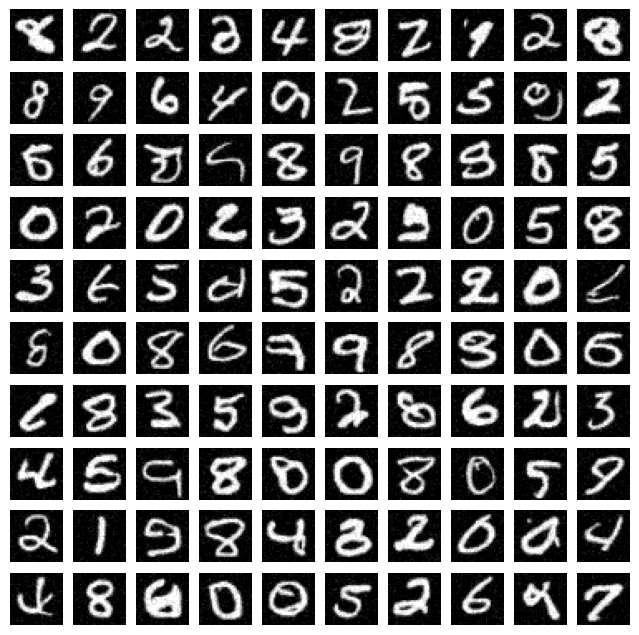

In [14]:
show_images(generated[999])

In [4]:
generate_video(generated, num_timesteps, file_title='arccos-0.999-evolution')

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [7]:
save_model(model, 'arccos-0.999')

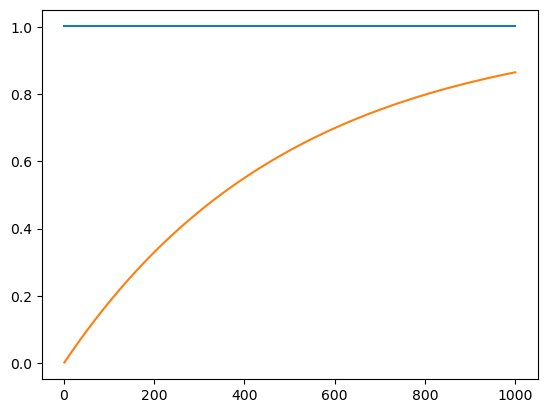

In [15]:
values_1 = []
values_2 = []

# mean formula 1: (betas[k-1] / torch.cos(etas[k-1]) + (alpha_ratio * tan_sq_eta)) / (tan_sq_eta + betas[k-1])
# mean formula 2: 1 / torch.cos(etas[k-1])
# noise formula 1: (alpha_ratio * (betas[k] ** 0.5) * tan_sq_eta) / (tan_sq_eta + betas[k-1]) #equivalent
# noise formula 2: (torch.sin(etas[k-1]) ** 2) / (torch.cos(etas[k-1]) * (betas[k-1] ** 0.5)) #equivalent
# variance formula 1: (tan_sq_eta * betas[k-1]) / (tan_sq_eta + betas[k-1]) #equivalent
# variance formula 2: (torch.sin(etas[k-1]) ** 2) * betas[k-1] / betas[k]   #equivalent

for k in range(1, num_timesteps+1):
    tan_sq_eta = torch.tan(etas[k-1]) ** 2
    alpha_ratio = alphas[k-1] / alphas[k]
    values_1.append(alpha_ratio)
    values_2.append(betas[k])

plt.plot(list(range(1, num_timesteps+1)), values_1)
plt.plot(list(range(1, num_timesteps+1)), values_2)

In [8]:
values_1

[tensor(22.3889),
 tensor(15.8392),
 tensor(12.9391),
 tensor(11.2113),
 tensor(10.0326),
 tensor(9.1630),
 tensor(8.4876),
 tensor(7.9434),
 tensor(7.4928),
 tensor(7.1119),
 tensor(6.7843),
 tensor(6.4987),
 tensor(6.2468),
 tensor(6.0226),
 tensor(5.8213),
 tensor(5.6392),
 tensor(5.4736),
 tensor(5.3220),
 tensor(5.1826),
 tensor(5.0539),
 tensor(4.9346),
 tensor(4.8235),
 tensor(4.7198),
 tensor(4.6228),
 tensor(4.5316),
 tensor(4.4458),
 tensor(4.3649),
 tensor(4.2883),
 tensor(4.2158),
 tensor(4.1470),
 tensor(4.0816),
 tensor(4.0193),
 tensor(3.9599),
 tensor(3.9032),
 tensor(3.8489),
 tensor(3.7970),
 tensor(3.7472),
 tensor(3.6993),
 tensor(3.6534),
 tensor(3.6092),
 tensor(3.5667),
 tensor(3.5257),
 tensor(3.4862),
 tensor(3.4481),
 tensor(3.4112),
 tensor(3.3756),
 tensor(3.3411),
 tensor(3.3078),
 tensor(3.2755),
 tensor(3.2442),
 tensor(3.2138),
 tensor(3.1843),
 tensor(3.1556),
 tensor(3.1278),
 tensor(3.1008),
 tensor(3.0745),
 tensor(3.0489),
 tensor(3.0240),
 tensor(2

In [9]:
values_2

[tensor(0.),
 tensor(0.5005),
 tensor(0.6673),
 tensor(0.7508),
 tensor(0.8008),
 tensor(0.8342),
 tensor(0.8580),
 tensor(0.8759),
 tensor(0.8898),
 tensor(0.9009),
 tensor(0.9100),
 tensor(0.9176),
 tensor(0.9240),
 tensor(0.9295),
 tensor(0.9343),
 tensor(0.9384),
 tensor(0.9421),
 tensor(0.9454),
 tensor(0.9483),
 tensor(0.9509),
 tensor(0.9533),
 tensor(0.9555),
 tensor(0.9575),
 tensor(0.9593),
 tensor(0.9610),
 tensor(0.9625),
 tensor(0.9639),
 tensor(0.9652),
 tensor(0.9665),
 tensor(0.9676),
 tensor(0.9687),
 tensor(0.9697),
 tensor(0.9707),
 tensor(0.9715),
 tensor(0.9724),
 tensor(0.9732),
 tensor(0.9739),
 tensor(0.9746),
 tensor(0.9753),
 tensor(0.9760),
 tensor(0.9766),
 tensor(0.9772),
 tensor(0.9777),
 tensor(0.9782),
 tensor(0.9787),
 tensor(0.9792),
 tensor(0.9797),
 tensor(0.9801),
 tensor(0.9806),
 tensor(0.9810),
 tensor(0.9814),
 tensor(0.9817),
 tensor(0.9821),
 tensor(0.9824),
 tensor(0.9828),
 tensor(0.9831),
 tensor(0.9834),
 tensor(0.9837),
 tensor(0.9840),
 